In [1]:
import torch
import pandas as pd
import numpy as np
from hysteresis.base import TorchHysteresis
from hysteresis.training import train_MSE
from hysteresis.polynomial import Polynomial
from hysteresis.visualization import plot_hysteresis_density
import matplotlib.pyplot as plt

In [2]:

fname = f'D:/APS/Q7Hysteresis' \
        f'/APSU_Q7_100017035_MinorHysteresisLoop-3_0000_000_00_procFld_01.csv'

data = pd.read_csv(fname, skiprows=5)
data = data.drop([0])

# get real h, m
h = torch.tensor(data['Current'].to_numpy(dtype=np.float64))
m = torch.tensor(data['BigB1'].to_numpy(dtype=np.float64))

h = (h - torch.min(h)) / (torch.max(h) - torch.min(h))
m = ((m - torch.min(m)) / (max(m) - min(m)))*2.0 - 1.0

0
1000
2000
3000
4000


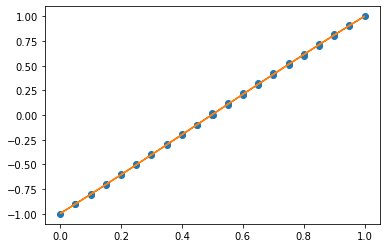

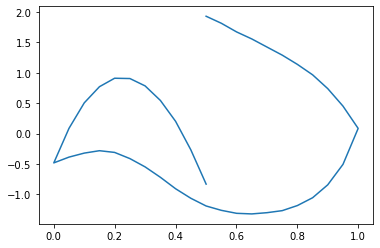

In [3]:
# create polynomial fit of data
poly = Polynomial(10)
train_MSE(poly, h, m, 5000, lr=0.1)

fig,ax = plt.subplots()
ax.plot(h, m,'o')
ax.plot(h, poly(h).detach().flatten())

m = m - poly(h)
norm_scale = torch.std(m)
m = m / norm_scale

fig,ax = plt.subplots()
ax.plot(h, m.detach())


In [4]:
h_train = h.detach()
m_train = m.detach()


# fit using normal hysteresis model
H = TorchHysteresis(h_train, mesh_scale = 0.03, temp=1e-3)
print(len(H.mesh_points))

726


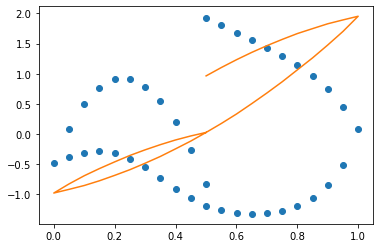

In [5]:
fig,ax = plt.subplots()
ax.plot(h_train, m_train,'o')
ax.plot(h_train, H.predict_magnetization_from_applied_fields().detach())

0
1000
2000
3000
4000
tensor(0.0017, dtype=torch.float64)
tensor(0.0017, dtype=torch.float64)
Parameter containing:
tensor([5.8756], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([6.3702], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-12.1516], dtype=torch.float64, requires_grad=True)


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_15100/2266689372.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.min(torch.tensor(loss_trace)))


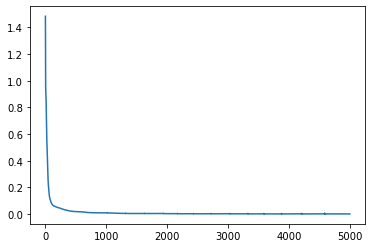

In [6]:
# train on data
loss_trace = train_MSE(H, h_train, m_train, 5000, lr=0.1, atol=1e-8)
fig, ax = plt.subplots()
ax.plot(loss_trace)
print(loss_trace[-1])
print(torch.min(torch.tensor(loss_trace)))
print(H.offset)
print(H.scale)
print(H.slope)

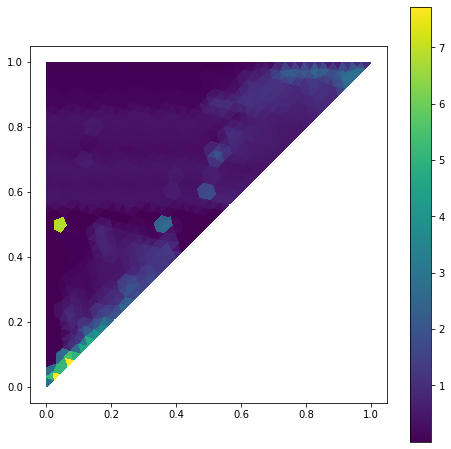

In [7]:
fig, ax = plot_hysteresis_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

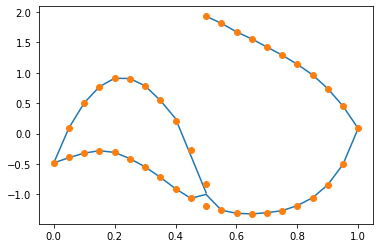

In [8]:
fig, ax = plt.subplots()
m_pred = H.predict_magnetization_from_applied_fields()
ax.plot(h_train, m_pred.detach())
ax.plot(h_train, m_train,'o')


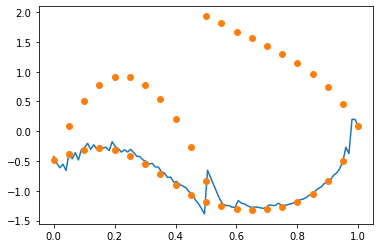

In [9]:
# plot prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

h_test = torch.linspace(0,1,100)

m_future = H.predict_magnetization_future(h_test)
ax2.plot(h_test, m_future.detach())
ax2.plot(h_train, m_train,'o')

#ax3b = ax3.twinx()
#ax3b.plot(h[n_train:], 'C1')
#print(torch.sqrt(torch.nn.MSELoss()(m_future, m[n_train:])))

[iteration 0001] loss: 200131.6554
[iteration 0101] loss: 13957.5855
[iteration 0201] loss: 7920.5711
[iteration 0301] loss: 11241.7430
[iteration 0401] loss: 5827.8751
[iteration 0501] loss: 7283.6977
[iteration 0601] loss: 4469.1691
[iteration 0701] loss: 4429.0307
[iteration 0801] loss: 6112.2043
[iteration 0901] loss: 3784.4068
[iteration 1001] loss: 3647.5335
[iteration 1101] loss: 3148.3904
[iteration 1201] loss: 2924.8872
[iteration 1301] loss: 4537.1805
[iteration 1401] loss: 3728.3272
[iteration 1501] loss: 3441.3859
[iteration 1601] loss: 3066.4674
[iteration 1701] loss: 4360.8247
[iteration 1801] loss: 2884.9193
[iteration 1901] loss: 3385.3841
[iteration 2001] loss: 2930.9103
[iteration 2101] loss: 2805.7030
[iteration 2201] loss: 2535.4595
[iteration 2301] loss: 2895.5394
[iteration 2401] loss: 2399.1408
[iteration 2501] loss: 3838.4799
[iteration 2601] loss: 2389.6641
[iteration 2701] loss: 2349.2896
[iteration 2801] loss: 2234.1085
[iteration 2901] loss: 2177.7252
[itera

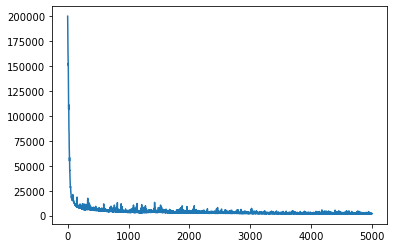

In [10]:
#train model using priors and MAP
from hysteresis.bayesian import BayesianHysteresis, positional_covariance
from hysteresis.training import map_bayes, train_bayes

def cov(model):
    return positional_covariance(model, 1.0) * 50.0

bh = BayesianHysteresis(H, kernel_function=cov)
guide, trace = train_bayes(h_train, m_train, bh, 5000, initial_lr=0.1)
plt.plot(trace)

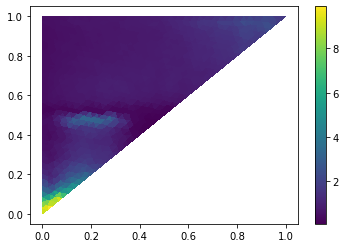

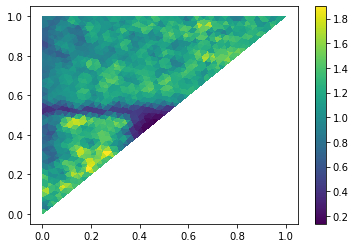

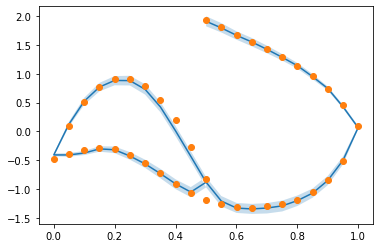

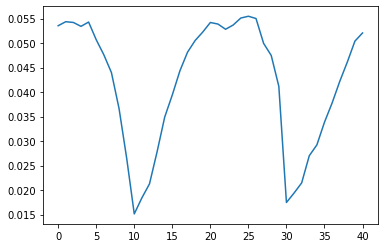

In [11]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density
pred_summary, samples = predict(h_train, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['mean'].flatten().detach())
)

# plot confidence width
fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['95%'].flatten().detach()) - \
    torch.nn.Softplus()(pred_summary['density']['5%'].flatten().detach())
)

fig, ax = plt.subplots()
ax.plot(h_train, mean.detach())
ax.plot(h_train, m_train,'o')
ax.fill_between(h_train, l, u, alpha=0.25)

fig3, ax3 = plt.subplots()
ax3.plot(pred_summary['obs']['std'])

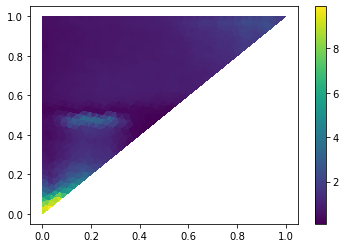

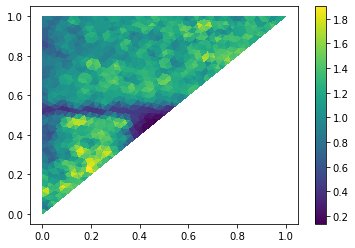

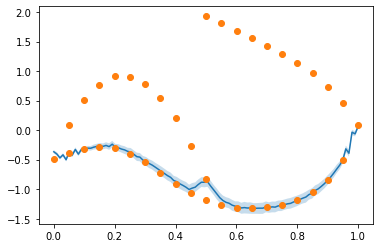

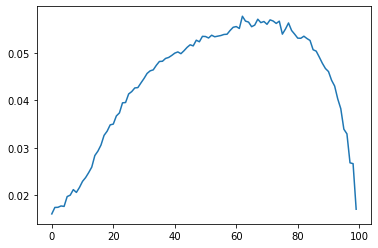

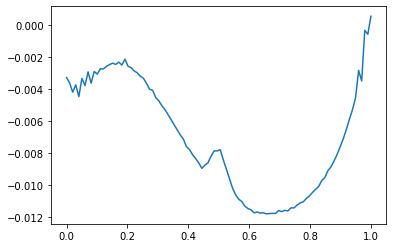

In [12]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density
h_test = torch.linspace(0,1.0,100)
bh.future()
pred_summary, samples = predict(h_test, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['mean'].flatten().detach())
)

# plot confidence width
fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['95%'].flatten().detach()) - \
    torch.nn.Softplus()(pred_summary['density']['5%'].flatten().detach())
)

fig, ax = plt.subplots()
ax.plot(h_test, mean.detach())
ax.plot(h_train, m_train,'o')
ax.fill_between(h_test, l, u, alpha=0.25)

fig3, ax3 = plt.subplots()
ax3.plot(pred_summary['obs']['std'])

fig, ax = plt.subplots()
ax.plot(h_test, mean.detach()*norm_scale.detach())